# Model Optimization using RMSprop

The purpose of this notebook is to present a workflow to optimize the training of a model using NWPU-Resic45 lake images and corresponding labels for the purposes of estimating lake area over time at sites represented in the Sentinel-2 imagery.

All models have been trained using `RMSprop` as the model's optimization algorithm.

## External Dependencies

In [1]:
colab = True

In [ ]:
if colab:
    !pip install rasterio
    #!pip install --default-timeout=1000 tensorflow-gpu==2.3

## Requirements

In [3]:
import os
import sys
module_path = os.path.abspath('deep-water')
if module_path not in sys.path:
    sys.path.append(module_path)

Import remaining dependencies.

In [4]:
import glob
import json
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pickle
import pprint
import rasterio
import random
import shutil
import tensorflow as tf
from metrics.diceLoss import dice_coef, dice_coef_loss
from metrics.jaccardIndex import mean_iou, iou_loss
from models.batchLoader import BatchLoader
from models.dataAugmentationLoader import DataAugmentationLoader
from models.callbacks import build_callbacks
from models.unet import Unet
from models.unetResidual import UnetResidual
from PIL import Image, ImageDraw
from tools.google_drive_downloader import GoogleDriveDownloader
%matplotlib inline

Verify if the notebook contains the expected Tensorflow version.

In [5]:
print("tensorflow version: ", tf.__version__)
assert tf.__version__ == '2.3.0'

tensorflow version:  2.3.0


Verify if there is a GPU allocated running in the background.

In [6]:
devices = tf.config.list_physical_devices('GPU')
assert type(devices[0]) == tf.python.eager.context.PhysicalDevice

The constants used in this notebook are defined as follows.

In [51]:
batch_size = 8
epochs = 500
image_size = (256, 256)
patience_early_stopping = 20
patience_reduce_lr_on_plateau = 10
model_optimizer = 'rmsprop'
baseline_file_id = '14vL-3083qM-MTjsZq-Xt3Rc0Nn7u6raP'
baseline_file_name = 'baseline_20200921.zip'
nwpu_image_train_folder = 'nwpu_images_train'
nwpu_mask_train_folder = 'nwpu_label_images_train'
nwpu_image_validation_folder = 'nwpu_images_validation'
nwpu_mask_validation_folder = 'nwpu_label_images_validation'
s2cloudless_image_folder = 's2cloudless_imagery'
s2cloudless_mask_folder = 's2cloudless_label_imagery'
histories = {}
results = {}

Download training and test datasets.

In [52]:
google_drive_downloader = GoogleDriveDownloader()
google_drive_downloader.download(baseline_file_id, baseline_file_name, True)

uncompressing baseline_20200921.zip... Done.
downloading baseline_20200921.zip... Done.


Remove temporary folder and file.

In [53]:
shutil.rmtree('__MACOSX')
os.remove(baseline_file_name)

## Helper Functions

Define a function to display the training history.

In [139]:
def plot_history(model_history, metric='mean_iou'):
    label = 'Mean IoU' if metric == 'mean_iou' else 'Validation Dice Coef'
    plt.figure(figsize=(10, 4))
    # Mean IoU
    plt.subplot(1, 2, 1)
    plt.plot(model_history.history[metric], label="train")
    plt.plot(model_history.history[f'val_{metric}'], label="validation")
    plt.ylim(0, 1)
    plt.axhline(y=0.85, color='r', linestyle='dashed')
    plt.title(f'{label} vs Epoch Number')
    plt.ylabel(label)
    plt.xlabel('Epoch number')
    plt.legend(loc='lower right')
    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(model_history.history['loss'], label="train")
    plt.plot(model_history.history['val_loss'], label="validation")
    plt.legend()
    plt.title("Loss vs Epoch Number")
    plt.ylabel('Loss')
    plt.xlabel('Epoch number')
    plt.legend(loc='upper right')
    plt.show()
    plt.close()

Define a function to display six samples of the training data.

In [55]:
def display_training_samples(batch_size, X):
    index = 1
    table_size = 6
    images_count = batch_size if batch_size < table_size else table_size
    plt.figure(figsize=(20, 2))
    for i in range(images_count):
        plt.subplot(1, images_count, index)
        plt.imshow(X_sample[i])
        index += 1
    plt.show()
    plt.close()

Save model training history on the disk.

In [56]:
def save_model_history(model_name, model_history):
    file_name = f'history_{model_name}.bin'
    pair_name_history = {model_name: model_history.history}
    with open(file_name, 'wb') as file:
        pickle.dump(pair_name_history, file)

Display model metrics.

In [57]:
def display_model_metrics(metrics):
    if 'dice' in model_name:
        print('Dice coeficient loss: {}'.format(metrics[0]))
        print('Dice coeficient: {}'.format(metrics[1]))
    else:
        print('Loss: {}'.format(metrics[0]))
        print('IoU: {}'.format(metrics[1]))
        print('IoU loss: {}'.format(metrics[2]))
        print('Dice coeficient: {}'.format(metrics[3]))
        print('Dice coeficient loss: {}'.format(metrics[4]))

Save mode metrics.

In [58]:
def save_model_metrics(model_name, metrics):
    if 'dice' in model_name:
        results[model_name] = {
            'dice_coef':metrics[0],
            'dice_coef_loss':metrics[1]
        }
    else:
        results[model_name] = {
            'loss':metrics[0],
            'iou':metrics[1],
            'iou_loss':metrics[2],
            'dice_coef':metrics[3],
            'dice_coef_loss':metrics[4]
        }

Define a function to display a list of training history.

In [59]:
def plot_histories(model_histories, metric='mean_iou'):
    label = 'Validation IoU' if metric == 'mean_iou' else 'Validation Dice Coef'
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    for title, history in model_histories.items():
        plt.plot(history.history[f'val_{metric}'], label=title)
        plt.ylim(0, 1)
        plt.title(f'{label} vs Epoch Number')
        plt.ylabel(label)
        plt.xlabel('Epoch number')
    plt.subplot(1, 2, 2)
    for title, history in model_histories.items():
        plt.plot(history.history["val_loss"], label=title)
        plt.title("Loss vs Epoch Number")
        plt.ylabel('Loss')
        plt.xlabel('Epoch number')
        plt.legend(loc='upper right')
    plt.show()
    plt.close()

Define a function to build the model's callbacks.

In [60]:
def build_callback_parameters(model_name, metric='val_loss'):
    callback_parameters = {}
    enable_csv_logger = False
    callback_reduce_lr_on_plateau = {
        'cooldown':5,
        'factor':0.2,
        'min_lr':0.0001,
        'min_delta':0.0001,
        'monitor':metric,
        'patience':patience_reduce_lr_on_plateau
    }
    if metric == 'val_loss':
        callback_parameters = {
            'model_name':model_name,
            'enable_csv_logger':enable_csv_logger,
            'early_stopping':{'mode':'min', 'monitor':'val_loss', 'patience':patience_early_stopping},
            'reduce_lr_on_plateau':callback_reduce_lr_on_plateau
        }
    elif metric == 'val_dice_coef':
        callback_parameters = {
            'model_name':model_name,
            'enable_csv_logger':enable_csv_logger,
            'reduce_lr_on_plateau':callback_reduce_lr_on_plateau
        }
    return callback_parameters

Defines a function to split the dataset into training, validation and test and display the number of the images for each dataset as well as the batch size.

In [61]:
def get_number_of_training_steps():
    # training
    train_files = glob.glob(os.path.join(nwpu_image_train_folder, 'data', '*.jpg'))
    train_file_count = len(train_files)
    train_steps = train_file_count // batch_size
    # validation
    validation_files = glob.glob(os.path.join(nwpu_image_validation_folder, 'data', '*.jpg'))
    validation_file_count = len(validation_files)
    validation_steps = validation_file_count // batch_size
    # display the number of images for each dataset as well as the batch size
    print("# training steps: {}".format(train_steps))
    print("# validation steps: {}".format(validation_steps))
    print("# batch size: {}".format(batch_size))
    return (train_steps, validation_steps)

Defines a function that creates a generator object for the training, validation and test datasets in order to feed the neural network.

In [62]:
def build_generators():
    test_files = glob.glob(os.path.join(s2cloudless_image_folder, 'data', '*.jpg'))
    test_file_count = len(test_files)
    test_loader = BatchLoader(test_files, s2cloudless_image_folder, s2cloudless_mask_folder, test_file_count, image_size)
    test_generator = test_loader()
    print("Test:")
    print("Found {} images.".format(test_file_count))
    train_loader = DataAugmentationLoader(nwpu_image_train_folder, nwpu_mask_train_folder, batch_size, image_size)
    print("Training:")
    train_generator = train_loader()
    validation_loader = DataAugmentationLoader(nwpu_image_validation_folder, nwpu_mask_validation_folder, batch_size, image_size)
    print("Validation:")
    validation_generator = validation_loader()
    return (train_generator, validation_generator, test_generator)

## Training Tuning Strategies

The following strategies will be explored in this section:
1. Using Early Stopping and Adaptive Learning Rates;
2. Using a bigger model (and dropout);
3. Using regularization (Batch Normalization);
4. Using residual connections;
4. Dealing with class imbalance using dice loss;
6. Refining label images using CRFs;
7. Ensemble predictions.

### Optimization strategy 1: Create a baseline model with Early Stopping and Adaptive Learning Rates

#### Prepare the data

Retrieve the number of training and validation steps for each epoch based on the total number of images and the batch size.

Create the train, validation and test generators. The train and validation images rely on the `DataAugmentationLoader` class to transform the images dynamicaly. The test generators will load all images from the test image folder using the `BatchLoader` class.

In [63]:
train_steps, validation_steps = get_number_of_training_steps()
train_generator, validation_generator, test_generator = build_generators()

# training steps: 61
# validation steps: 26
# batch size: 8
Test:
Found 359 images.
Training:
Found 489 images belonging to 1 classes.
Found 489 images belonging to 1 classes.
Validation:
Found 211 images belonging to 1 classes.
Found 211 images belonging to 1 classes.


#### Display a few samples from the training dataset

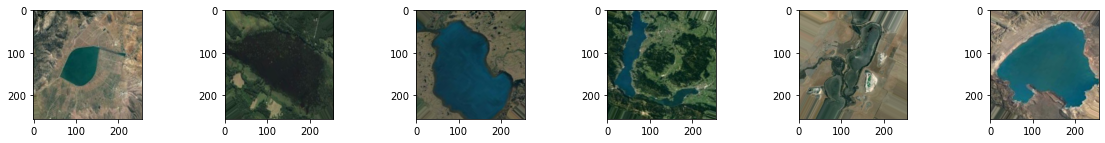

In [64]:
X_sample, Y_sample = next(train_generator)
display_training_samples(batch_size, X_sample)

#### Display a few samples from the validation dataset

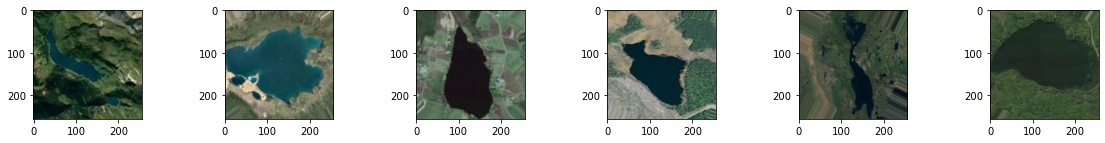

In [65]:
X_sample, Y_sample = next(validation_generator)
display_training_samples(batch_size, X_sample)

#### Display a few samples from the test dataset

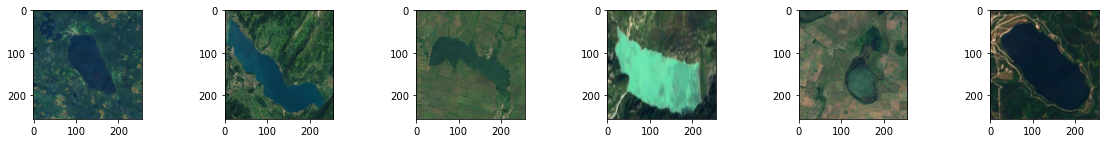

In [66]:
X_sample, Y_sample = next(test_generator)
display_training_samples(batch_size, X_sample)

#### Create the model and attach optimizer, loss, and metrics

In [67]:
unet_baseline = Unet('unet-baseline', image_size)
model_name = unet_baseline.model_name
unet_baseline.set_compiler('binary_crossentropy', metrics=[mean_iou, iou_loss, dice_coef, dice_coef_loss], optimizer=model_optimizer)

#### Model summary

The summary of the model architecture that will be used for the baseline can be find detailed below.

In [68]:
unet_baseline.get_model_summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_54 (Conv2D)              (None, 256, 256, 8)  224         input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_55 (Conv2D)              (None, 256, 256, 8)  584         conv2d_54[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_12 (MaxPooling2D) (None, 128, 128, 8)  0           conv2d_55[0][0]                  
_______________________________________________________________________________________

#### Evaluating the model before training

In [69]:
X_test, Y_test = next(test_generator)
metrics = unet_baseline.evaluate(X_test, Y_test)
display_model_metrics(metrics)

Loss: 0.6987935304641724
IoU: 0.14469219744205475
IoU loss: 0.8553078174591064
Dice coeficient: 0.25395873188972473
Dice coeficient loss: 0.7460412979125977


#### Setup callbacks and fit the model

In [70]:
callback_parameters = build_callback_parameters(model_name, 'val_loss')
callbacks = build_callbacks(callback_parameters)
unet_baseline.fit(train_generator, train_steps, validation_generator, validation_steps, epochs, callbacks)
histories[model_name] = unet_baseline.history

Epoch 1/500
61/61 [==============================] - 15s 241ms/step - loss: 0.7502 - mean_iou: 0.0038 - iou_loss: 0.9962 - dice_coef: 0.2780 - dice_coef_loss: 0.7220 - val_loss: 0.4921 - val_mean_iou: 0.0031 - val_iou_loss: 0.9969 - val_dice_coef: 0.3438 - val_dice_coef_loss: 0.6562
Epoch 2/500
61/61 [==============================] - 15s 243ms/step - loss: 0.3548 - mean_iou: 0.3378 - iou_loss: 0.6622 - dice_coef: 0.4426 - dice_coef_loss: 0.5574 - val_loss: 0.2941 - val_mean_iou: 0.5189 - val_iou_loss: 0.4811 - val_dice_coef: 0.5408 - val_dice_coef_loss: 0.4592
Epoch 3/500
61/61 [==============================] - 15s 241ms/step - loss: 0.3430 - mean_iou: 0.6131 - iou_loss: 0.3869 - dice_coef: 0.6047 - dice_coef_loss: 0.3953 - val_loss: 0.2659 - val_mean_iou: 0.6202 - val_iou_loss: 0.3798 - val_dice_coef: 0.6342 - val_dice_coef_loss: 0.3658
Epoch 4/500
61/61 [==============================] - 14s 230ms/step - loss: 0.2669 - mean_iou: 0.6403 - iou_loss: 0.3597 - dice_coef: 0.6572 - dice_

#### Inspect and save the history

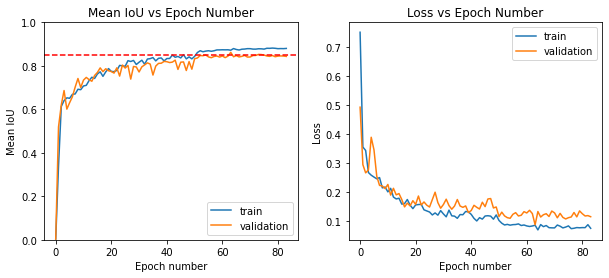

In [71]:
plot_history(unet_baseline.history)
save_model_history(model_name, unet_baseline.history)

#### Evaluating the model after training

In [72]:
metrics = unet_baseline.evaluate(X_test, Y_test)
display_model_metrics(metrics)
save_model_metrics(model_name, metrics)

Loss: 0.20768220722675323
IoU: 0.7023693919181824
IoU loss: 0.29763063788414
Dice coeficient: 0.7879212498664856
Dice coeficient loss: 0.21207869052886963


Delete the model.

In [73]:
del unet_baseline

### Optimization strategy 2: Changing model architecture using a bigger rocket

#### Prepare the data

Retrieve the number of training and validation steps for each epoch based on the total number of images and the batch size.

Create the train, validation and test generators. The train and validation images rely on the `DataAugmentationLoader` class to transform the images dynamicaly. The test generators will load all images from the test image folder using the `BatchLoader` class.

In [74]:
train_steps, validation_steps = get_number_of_training_steps()
train_generator, validation_generator, test_generator = build_generators()

# training steps: 61
# validation steps: 26
# batch size: 8
Test:
Found 359 images.
Training:
Found 489 images belonging to 1 classes.
Found 489 images belonging to 1 classes.
Validation:
Found 211 images belonging to 1 classes.
Found 211 images belonging to 1 classes.


#### Display a few samples from the training dataset

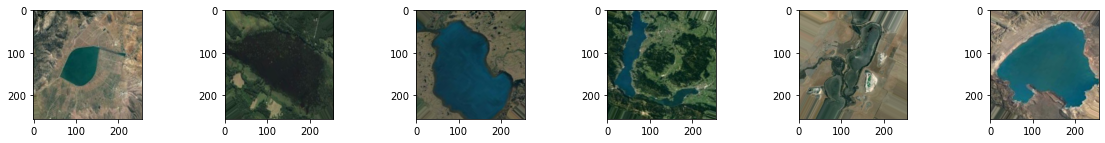

In [75]:
X_sample, Y_sample = next(train_generator)
display_training_samples(batch_size, X_sample)

#### Create the model and attach optimizer, loss, and metrics

In [76]:
unet_large = Unet('unet-large', image_size, version=2)
model_name = unet_large.model_name
unet_large.set_compiler('binary_crossentropy', metrics=[mean_iou, iou_loss, dice_coef, dice_coef_loss], optimizer=model_optimizer)

#### Model summary

The summary of this more robust model with more than 26 million parameters can be find detailed below.

In [77]:
unet_large.get_model_summary()

Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_81 (Conv2D)              (None, 256, 256, 16) 448         input_4[0][0]                    
__________________________________________________________________________________________________
conv2d_82 (Conv2D)              (None, 256, 256, 16) 2320        conv2d_81[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_18 (MaxPooling2D) (None, 128, 128, 16) 0           conv2d_82[0][0]                  
_______________________________________________________________________________________

#### Evaluating the model before training

In [78]:
X_test, Y_test = next(test_generator)
metrics = unet_large.evaluate(X_test, Y_test)
display_model_metrics(metrics)

Loss: 0.7147125005722046
IoU: 0.1795760542154312
IoU loss: 0.8204239010810852
Dice coeficient: 0.2610764801502228
Dice coeficient loss: 0.7389235496520996


#### Setup callbacks and fit the model

In [79]:
callback_parameters = build_callback_parameters(model_name, 'val_loss')
callbacks = build_callbacks(callback_parameters)
unet_large.fit(train_generator, train_steps, validation_generator, validation_steps, epochs, callbacks)
histories[model_name] = unet_large.history

Epoch 1/500
61/61 [==============================] - 26s 423ms/step - loss: 0.4299 - mean_iou: 0.1789 - iou_loss: 0.8211 - dice_coef: 0.3745 - dice_coef_loss: 0.6255 - val_loss: 0.7985 - val_mean_iou: 0.2459 - val_iou_loss: 0.7541 - val_dice_coef: 0.3555 - val_dice_coef_loss: 0.6445
Epoch 2/500
61/61 [==============================] - 25s 412ms/step - loss: 0.3175 - mean_iou: 0.5900 - iou_loss: 0.4100 - dice_coef: 0.5790 - dice_coef_loss: 0.4210 - val_loss: 0.3774 - val_mean_iou: 0.2390 - val_iou_loss: 0.7610 - val_dice_coef: 0.4434 - val_dice_coef_loss: 0.5566
Epoch 3/500
61/61 [==============================] - 25s 414ms/step - loss: 0.4479 - mean_iou: 0.5706 - iou_loss: 0.4294 - dice_coef: 0.5605 - dice_coef_loss: 0.4395 - val_loss: 0.2391 - val_mean_iou: 0.6264 - val_iou_loss: 0.3736 - val_dice_coef: 0.6268 - val_dice_coef_loss: 0.3732
Epoch 4/500
61/61 [==============================] - 24s 398ms/step - loss: 0.2686 - mean_iou: 0.6434 - iou_loss: 0.3566 - dice_coef: 0.6533 - dice_

#### Inspect and save the history

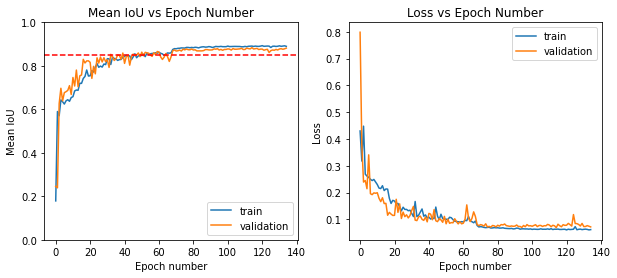

In [80]:
plot_history(unet_large.history)
save_model_history(model_name, unet_large.history)

#### Evaluating the model after training

In [81]:
metrics = unet_large.evaluate(X_test, Y_test)
display_model_metrics(metrics)
save_model_metrics(model_name, metrics)

Loss: 0.2383989691734314
IoU: 0.656050980091095
IoU loss: 0.3439490497112274
Dice coeficient: 0.7636394500732422
Dice coeficient loss: 0.23636047542095184


Delete the model.

In [82]:
del unet_large

### Optimization strategy 3.1: Changing baseline architecture using a batch normalization

#### Prepare the data

Retrieve the number of training and validation steps for each epoch based on the total number of images and the batch size.

Create the train, validation and test generators. The train and validation images rely on the `DataAugmentationLoader` class to transform the images dynamicaly. The test generators will load all images from the test image folder using the `BatchLoader` class.

In [83]:
train_steps, validation_steps = get_number_of_training_steps()
train_generator, validation_generator, test_generator = build_generators()

# training steps: 61
# validation steps: 26
# batch size: 8
Test:
Found 359 images.
Training:
Found 489 images belonging to 1 classes.
Found 489 images belonging to 1 classes.
Validation:
Found 211 images belonging to 1 classes.
Found 211 images belonging to 1 classes.


#### Display a few samples from the training dataset

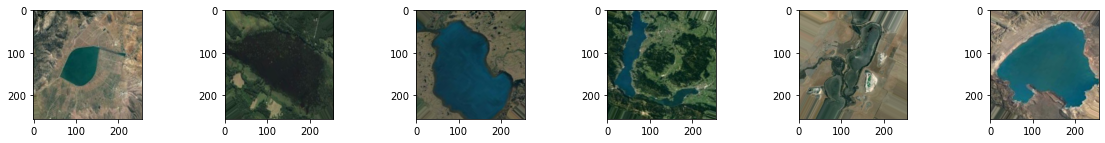

In [84]:
X_sample, Y_sample = next(train_generator)
display_training_samples(batch_size, X_sample)

#### Create the model and attach optimizer, loss, and metrics

In [85]:
unet_batch_normalization = Unet('unet-batch-normalization', image_size, version=3)
model_name = unet_batch_normalization.model_name
unet_batch_normalization.set_compiler('binary_crossentropy', metrics=[mean_iou, iou_loss, dice_coef, dice_coef_loss], optimizer=model_optimizer)

#### Model summary

The summary of this architecture with batch normalization can be find detailed below.

In [86]:
unet_batch_normalization.get_model_summary()

Model: "functional_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_108 (Conv2D)             (None, 256, 256, 8)  224         input_5[0][0]                    
__________________________________________________________________________________________________
conv2d_109 (Conv2D)             (None, 256, 256, 8)  584         conv2d_108[0][0]                 
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 8)  32          conv2d_109[0][0]                 
_______________________________________________________________________________________

#### Evaluating the model before training

In [87]:
X_test, Y_test = next(test_generator)
metrics = unet_batch_normalization.evaluate(X_test, Y_test)
display_model_metrics(metrics)

Loss: 0.6871945858001709
IoU: 0.005685111507773399
IoU loss: 0.9943148493766785
Dice coeficient: 0.26706811785697937
Dice coeficient loss: 0.7329318523406982


#### Setup callbacks and fit the model

In [88]:
callback_parameters = build_callback_parameters(model_name, 'val_loss')
callbacks = build_callbacks(callback_parameters)
unet_batch_normalization.fit(train_generator, train_steps, validation_generator, validation_steps, epochs, callbacks)
histories[model_name] = unet_batch_normalization.history

Epoch 1/500
61/61 [==============================] - 14s 229ms/step - loss: 0.6507 - mean_iou: 0.4975 - iou_loss: 0.5025 - dice_coef: 0.5313 - dice_coef_loss: 0.4687 - val_loss: 0.5094 - val_mean_iou: 0.0000e+00 - val_iou_loss: 1.0000 - val_dice_coef: 0.2716 - val_dice_coef_loss: 0.7284
Epoch 2/500
61/61 [==============================] - 14s 222ms/step - loss: 0.2292 - mean_iou: 0.6825 - iou_loss: 0.3175 - dice_coef: 0.7027 - dice_coef_loss: 0.2973 - val_loss: 0.4791 - val_mean_iou: 0.0000e+00 - val_iou_loss: 1.0000 - val_dice_coef: 0.2444 - val_dice_coef_loss: 0.7556
Epoch 3/500
61/61 [==============================] - 14s 223ms/step - loss: 0.2025 - mean_iou: 0.6956 - iou_loss: 0.3044 - dice_coef: 0.7375 - dice_coef_loss: 0.2625 - val_loss: 0.5810 - val_mean_iou: 0.0011 - val_iou_loss: 0.9989 - val_dice_coef: 0.1679 - val_dice_coef_loss: 0.8321
Epoch 4/500
61/61 [==============================] - 13s 220ms/step - loss: 0.1992 - mean_iou: 0.7005 - iou_loss: 0.2995 - dice_coef: 0.7449

#### Inspect and save the history

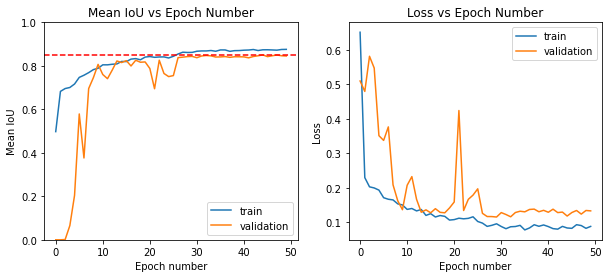

In [89]:
plot_history(unet_batch_normalization.history)
save_model_history(model_name, unet_batch_normalization.history)

#### Evaluating the model after training

In [90]:
metrics = unet_batch_normalization.evaluate(X_test, Y_test)
display_model_metrics(metrics)
save_model_metrics(model_name, metrics)

Loss: 0.29382801055908203
IoU: 0.6679607033729553
IoU loss: 0.33203932642936707
Dice coeficient: 0.7722836136817932
Dice coeficient loss: 0.227716326713562


Delete the model.

In [91]:
del unet_batch_normalization

### Optimization strategy 3.2: Changing large architecture using a batch normalization

#### Prepare the data

Retrieve the number of training and validation steps for each epoch based on the total number of images and the batch size.

Create the train, validation and test generators. The train and validation images rely on the `DataAugmentationLoader` class to transform the images dynamicaly. The test generators will load all images from the test image folder using the `BatchLoader` class.

In [92]:
train_steps, validation_steps = get_number_of_training_steps()
train_generator, validation_generator, test_generator = build_generators()

# training steps: 61
# validation steps: 26
# batch size: 8
Test:
Found 359 images.
Training:
Found 489 images belonging to 1 classes.
Found 489 images belonging to 1 classes.
Validation:
Found 211 images belonging to 1 classes.
Found 211 images belonging to 1 classes.


#### Display a few samples from the training dataset

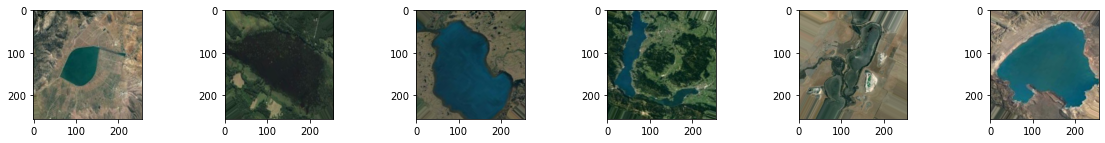

In [93]:
X_sample, Y_sample = next(train_generator)
display_training_samples(batch_size, X_sample)

#### Create the model and attach optimizer, loss, and metrics

In [94]:
unet_large_batch_normalization = Unet('unet-batch-normalization-large', image_size, version=4)
model_name = unet_large_batch_normalization.model_name
unet_large_batch_normalization.set_compiler('binary_crossentropy', metrics=[mean_iou, iou_loss, dice_coef, dice_coef_loss], optimizer=model_optimizer)

#### Model summary

In [95]:
unet_large_batch_normalization.get_model_summary()

Model: "functional_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_135 (Conv2D)             (None, 256, 256, 16) 448         input_6[0][0]                    
__________________________________________________________________________________________________
conv2d_136 (Conv2D)             (None, 256, 256, 16) 2320        conv2d_135[0][0]                 
__________________________________________________________________________________________________
batch_normalization_6 (BatchNor (None, 256, 256, 16) 64          conv2d_136[0][0]                 
______________________________________________________________________________________

#### Evaluating the model before training

In [96]:
X_test, Y_test = next(test_generator)
metrics = unet_large_batch_normalization.evaluate(X_test, Y_test)
display_model_metrics(metrics)

Loss: 0.6947153806686401
IoU: 0.17960800230503082
IoU loss: 0.8203920722007751
Dice coeficient: 0.2505780756473541
Dice coeficient loss: 0.7494218945503235


#### Setup callbacks and fit the model

In [97]:
callback_parameters = build_callback_parameters(model_name, 'val_loss')
callbacks = build_callbacks(callback_parameters)
unet_large_batch_normalization.fit(train_generator, train_steps, validation_generator, validation_steps, epochs, callbacks)
histories[model_name] = unet_large_batch_normalization.history

Epoch 1/500
61/61 [==============================] - 25s 416ms/step - loss: 3.3126 - mean_iou: 0.5060 - iou_loss: 0.4940 - dice_coef: 0.4723 - dice_coef_loss: 0.5277 - val_loss: 0.5271 - val_mean_iou: 0.0000e+00 - val_iou_loss: 1.0000 - val_dice_coef: 0.2706 - val_dice_coef_loss: 0.7294
Epoch 2/500
61/61 [==============================] - 25s 407ms/step - loss: 0.2513 - mean_iou: 0.6611 - iou_loss: 0.3389 - dice_coef: 0.6771 - dice_coef_loss: 0.3229 - val_loss: 0.5381 - val_mean_iou: 0.0000e+00 - val_iou_loss: 1.0000 - val_dice_coef: 0.1856 - val_dice_coef_loss: 0.8144
Epoch 3/500
61/61 [==============================] - 25s 406ms/step - loss: 0.2424 - mean_iou: 0.6749 - iou_loss: 0.3251 - dice_coef: 0.7037 - dice_coef_loss: 0.2963 - val_loss: 0.6589 - val_mean_iou: 0.0000e+00 - val_iou_loss: 1.0000 - val_dice_coef: 0.1068 - val_dice_coef_loss: 0.8932
Epoch 4/500
61/61 [==============================] - 25s 407ms/step - loss: 3.6621 - mean_iou: 0.6845 - iou_loss: 0.3155 - dice_coef: 0.

#### Inspect and save the history

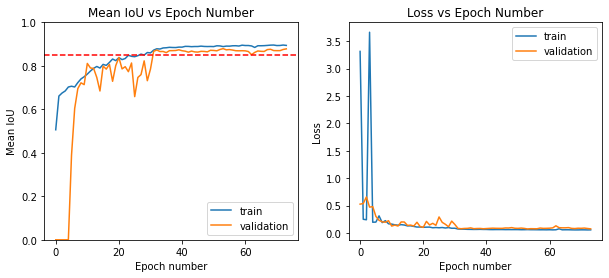

In [98]:
plot_history(unet_large_batch_normalization.history)
save_model_history(model_name, unet_large_batch_normalization.history)

#### Evaluating the model after training

In [99]:
metrics = unet_large_batch_normalization.evaluate(X_test, Y_test)
display_model_metrics(metrics)
save_model_metrics(model_name, metrics)

Loss: 0.23929846286773682
IoU: 0.6668804287910461
IoU loss: 0.33311963081359863
Dice coeficient: 0.757493257522583
Dice coeficient loss: 0.24250678718090057


In [100]:
del unet_large_batch_normalization

Delete the model.

### Optimization strategy 4.1: Changing model architecture using residual connections

#### Prepare the data

Retrieve the number of training and validation steps for each epoch based on the total number of images and the batch size.

Create the train, validation and test generators. The train and validation images rely on the `DataAugmentationLoader` class to transform the images dynamicaly. The test generators will load all images from the test image folder using the `BatchLoader` class.

In [101]:
train_steps, validation_steps = get_number_of_training_steps()
train_generator, validation_generator, test_generator = build_generators()

# training steps: 61
# validation steps: 26
# batch size: 8
Test:
Found 359 images.
Training:
Found 489 images belonging to 1 classes.
Found 489 images belonging to 1 classes.
Validation:
Found 211 images belonging to 1 classes.
Found 211 images belonging to 1 classes.


#### Display a few samples from the training dataset

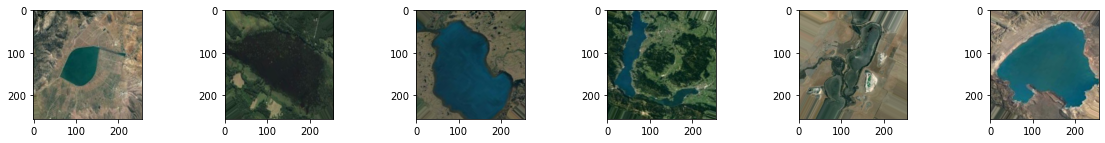

In [102]:
X_sample, Y_sample = next(train_generator)
display_training_samples(batch_size, X_sample)

#### Create the model and attach optimizer, loss, and metrics

In [103]:
unet_residual = UnetResidual('unet-residual', image_size)
model_name = unet_residual.model_name
unet_residual.set_compiler('binary_crossentropy', metrics=[mean_iou, iou_loss, dice_coef, dice_coef_loss], optimizer=model_optimizer)

#### Model summary

In [104]:
unet_residual.get_model_summary()

Model: "functional_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_162 (Conv2D)             (None, 256, 256, 16) 448         input_7[0][0]                    
__________________________________________________________________________________________________
batch_normalization_12 (BatchNo (None, 256, 256, 16) 64          conv2d_162[0][0]                 
__________________________________________________________________________________________________
conv2d_164 (Conv2D)             (None, 256, 256, 16) 64          input_7[0][0]                    
______________________________________________________________________________________

#### Evaluating the model before training

In [105]:
X_test, Y_test = next(test_generator)
metrics = unet_residual.evaluate(X_test, Y_test)
display_model_metrics(metrics)

Loss: 0.7194000482559204
IoU: 0.16762857139110565
IoU loss: 0.8323714733123779
Dice coeficient: 0.24961191415786743
Dice coeficient loss: 0.7503880858421326


#### Setup callbacks and fit the model

In [106]:
callback_parameters = build_callback_parameters(model_name, 'val_loss')
callbacks = build_callbacks(callback_parameters)
unet_residual.fit(train_generator, train_steps, validation_generator, validation_steps, epochs, callbacks)
histories[model_name] = unet_residual.history

Epoch 1/500
61/61 [==============================] - 18s 300ms/step - loss: 0.2785 - mean_iou: 0.6150 - iou_loss: 0.3850 - dice_coef: 0.6733 - dice_coef_loss: 0.3267 - val_loss: 1.1424 - val_mean_iou: 0.0000e+00 - val_iou_loss: 1.0000 - val_dice_coef: 0.0298 - val_dice_coef_loss: 0.9702
Epoch 2/500
61/61 [==============================] - 17s 278ms/step - loss: 0.2155 - mean_iou: 0.6906 - iou_loss: 0.3094 - dice_coef: 0.7301 - dice_coef_loss: 0.2699 - val_loss: 1.1962 - val_mean_iou: 0.2632 - val_iou_loss: 0.7368 - val_dice_coef: 0.4053 - val_dice_coef_loss: 0.5947
Epoch 3/500
61/61 [==============================] - 17s 281ms/step - loss: 0.1903 - mean_iou: 0.7189 - iou_loss: 0.2811 - dice_coef: 0.7525 - dice_coef_loss: 0.2475 - val_loss: 0.5045 - val_mean_iou: 0.0020 - val_iou_loss: 0.9980 - val_dice_coef: 0.1997 - val_dice_coef_loss: 0.8003
Epoch 4/500
61/61 [==============================] - 17s 278ms/step - loss: 0.1766 - mean_iou: 0.7323 - iou_loss: 0.2677 - dice_coef: 0.7719 - d

#### Inspect and save the history

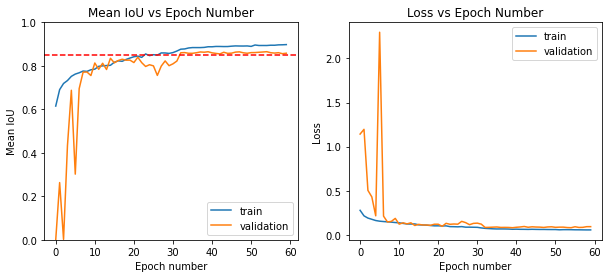

In [107]:
plot_history(unet_residual.history)
save_model_history(model_name, unet_residual.history)

#### Evaluating the model after training

In [108]:
metrics = unet_residual.evaluate(X_test, Y_test)
display_model_metrics(metrics)
save_model_metrics(model_name, metrics)

Loss: 0.4314119517803192
IoU: 0.5792807936668396
IoU loss: 0.4207192361354828
Dice coeficient: 0.700941264629364
Dice coeficient loss: 0.299058735370636


Dele

### Optimization strategy 4.2: Changing model architecture using residual connections and bigger filters

#### Prepare the data

Retrieve the number of training and validation steps for each epoch based on the total number of images and the batch size.

Create the train, validation and test generators. The train and validation images rely on the `DataAugmentationLoader` class to transform the images dynamicaly. The test generators will load all images from the test image folder using the `BatchLoader` class.

In [109]:
train_steps, validation_steps = get_number_of_training_steps()
train_generator, validation_generator, test_generator = build_generators()

# training steps: 61
# validation steps: 26
# batch size: 8
Test:
Found 359 images.
Training:
Found 489 images belonging to 1 classes.
Found 489 images belonging to 1 classes.
Validation:
Found 211 images belonging to 1 classes.
Found 211 images belonging to 1 classes.


#### Display a few samples from the training dataset

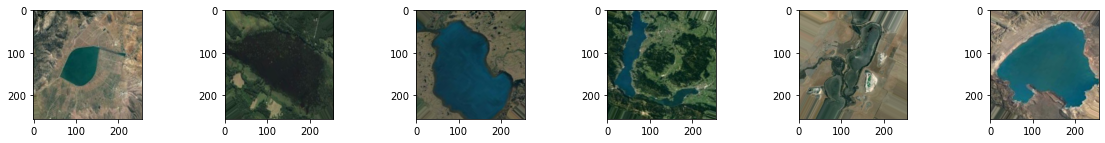

In [110]:
X_sample, Y_sample = next(train_generator)
display_training_samples(batch_size, X_sample)

#### Create the model and attach optimizer, loss, and metrics

In [111]:
unet_residual_large = UnetResidual('unet-residual-large', image_size, version=2)
model_name = unet_residual.model_name
unet_residual_large.set_compiler('binary_crossentropy', metrics=[mean_iou, iou_loss, dice_coef, dice_coef_loss], optimizer=model_optimizer)

#### Model summary

In [112]:
unet_residual_large.get_model_summary()

Model: "functional_15"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_192 (Conv2D)             (None, 256, 256, 32) 896         input_8[0][0]                    
__________________________________________________________________________________________________
batch_normalization_40 (BatchNo (None, 256, 256, 32) 128         conv2d_192[0][0]                 
__________________________________________________________________________________________________
conv2d_194 (Conv2D)             (None, 256, 256, 32) 128         input_8[0][0]                    
______________________________________________________________________________________

#### Evaluating the model before training

In [113]:
X_test, Y_test = next(test_generator)
metrics = unet_residual_large.evaluate(X_test, Y_test)
display_model_metrics(metrics)

Loss: 0.7859395742416382
IoU: 0.1740965098142624
IoU loss: 0.8259034752845764
Dice coeficient: 0.2593119740486145
Dice coeficient loss: 0.7406880259513855


#### Setup callbacks and fit the model

In [114]:
callback_parameters = build_callback_parameters(model_name, 'val_loss')
callbacks = build_callbacks(callback_parameters)
unet_residual_large.fit(train_generator, train_steps, validation_generator, validation_steps, epochs, callbacks)
histories[model_name] = unet_residual_large.history

Epoch 1/500
61/61 [==============================] - 38s 629ms/step - loss: 0.3266 - mean_iou: 0.6011 - iou_loss: 0.3989 - dice_coef: 0.6559 - dice_coef_loss: 0.3441 - val_loss: 1.0895 - val_mean_iou: 0.2226 - val_iou_loss: 0.7774 - val_dice_coef: 0.3408 - val_dice_coef_loss: 0.6592
Epoch 2/500
61/61 [==============================] - 36s 596ms/step - loss: 0.2553 - mean_iou: 0.6582 - iou_loss: 0.3418 - dice_coef: 0.6983 - dice_coef_loss: 0.3017 - val_loss: 2.8966 - val_mean_iou: 0.2417 - val_iou_loss: 0.7583 - val_dice_coef: 0.3892 - val_dice_coef_loss: 0.6108
Epoch 3/500
61/61 [==============================] - 37s 599ms/step - loss: 0.2300 - mean_iou: 0.6761 - iou_loss: 0.3239 - dice_coef: 0.7204 - dice_coef_loss: 0.2796 - val_loss: 1.2876 - val_mean_iou: 0.0059 - val_iou_loss: 0.9941 - val_dice_coef: 0.0536 - val_dice_coef_loss: 0.9464
Epoch 4/500
61/61 [==============================] - 37s 600ms/step - loss: 0.2355 - mean_iou: 0.6659 - iou_loss: 0.3341 - dice_coef: 0.7173 - dice_

#### Inspect and save the history

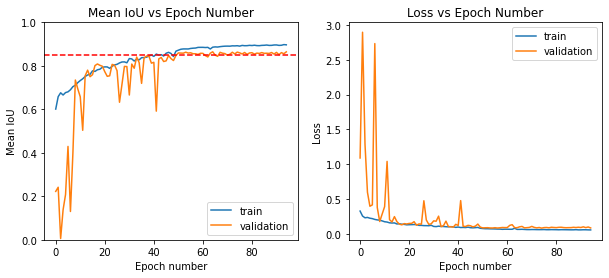

In [115]:
plot_history(unet_residual_large.history)
save_model_history(model_name, unet_residual_large.history)

#### Evaluating the model after training

In [116]:
metrics = unet_residual_large.evaluate(X_test, Y_test)
display_model_metrics(metrics)
save_model_metrics(model_name, metrics)

Loss: 0.7492512464523315
IoU: 0.47400832176208496
IoU loss: 0.525991678237915
Dice coeficient: 0.628169059753418
Dice coeficient loss: 0.37183094024658203


Delete the model.

In [117]:
del unet_residual_large

### Optimization strategy 5.1: Dealing with class imbalance using dice loss

#### Prepare the data

Retrieve the number of training and validation steps for each epoch based on the total number of images and the batch size.

Create the train, validation and test generators. The train and validation images rely on the `DataAugmentationLoader` class to transform the images dynamicaly. The test generators will load all images from the test image folder using the `BatchLoader` class.

In [118]:
train_steps, validation_steps = get_number_of_training_steps()
train_generator, validation_generator, test_generator = build_generators()

# training steps: 61
# validation steps: 26
# batch size: 8
Test:
Found 359 images.
Training:
Found 489 images belonging to 1 classes.
Found 489 images belonging to 1 classes.
Validation:
Found 211 images belonging to 1 classes.
Found 211 images belonging to 1 classes.


#### Display a few samples from the training dataset

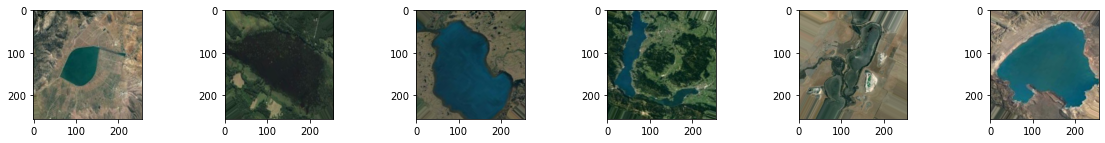

In [119]:
X_sample, Y_sample = next(train_generator)
display_training_samples(batch_size, X_sample)

#### Create the model and attach optimizer, loss, and metrics

In [120]:
unet_residual_dice = UnetResidual('unet-residual-dice', image_size)
model_name = unet_residual_dice.model_name
unet_residual_dice.set_compiler(dice_coef_loss, metrics=[dice_coef], optimizer=model_optimizer)

#### Model summary

In [121]:
unet_residual_dice.get_model_summary()

Model: "functional_17"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_222 (Conv2D)             (None, 256, 256, 16) 448         input_9[0][0]                    
__________________________________________________________________________________________________
batch_normalization_68 (BatchNo (None, 256, 256, 16) 64          conv2d_222[0][0]                 
__________________________________________________________________________________________________
conv2d_224 (Conv2D)             (None, 256, 256, 16) 64          input_9[0][0]                    
______________________________________________________________________________________

#### Evaluating the model before training

In [122]:
X_test, Y_test = next(test_generator)
metrics = unet_residual_dice.evaluate(X_test, Y_test)
display_model_metrics(metrics)

Dice coeficient loss: 0.7364121079444885
Dice coeficient: 0.2637210786342621


#### Setup callbacks and fit the model

In [123]:
callback_parameters = build_callback_parameters(model_name, 'val_dice_coef')
callbacks = build_callbacks(callback_parameters)
unet_residual_dice.fit(train_generator, train_steps, validation_generator, validation_steps, epochs, callbacks)
histories[model_name] = unet_residual_dice.history

Epoch 1/500
61/61 [==============================] - 17s 286ms/step - loss: 0.2356 - dice_coef: 0.7613 - val_loss: 0.9830 - val_dice_coef: 0.0170
Epoch 2/500
61/61 [==============================] - 17s 287ms/step - loss: 0.1971 - dice_coef: 0.8029 - val_loss: 0.5670 - val_dice_coef: 0.4330
Epoch 3/500
61/61 [==============================] - 17s 284ms/step - loss: 0.1913 - dice_coef: 0.8052 - val_loss: 0.5234 - val_dice_coef: 0.4766
Epoch 4/500
61/61 [==============================] - 17s 277ms/step - loss: 0.1817 - dice_coef: 0.8165 - val_loss: 0.9764 - val_dice_coef: 0.0236
Epoch 5/500
61/61 [==============================] - 17s 278ms/step - loss: 0.1632 - dice_coef: 0.8324 - val_loss: 0.8548 - val_dice_coef: 0.1452
Epoch 6/500
61/61 [==============================] - 17s 279ms/step - loss: 0.1547 - dice_coef: 0.8449 - val_loss: 0.1734 - val_dice_coef: 0.8266
Epoch 7/500
61/61 [==============================] - 17s 277ms/step - loss: 0.1436 - dice_coef: 0.8554 - val_loss: 0.2090 - 

#### Inspect and save the history

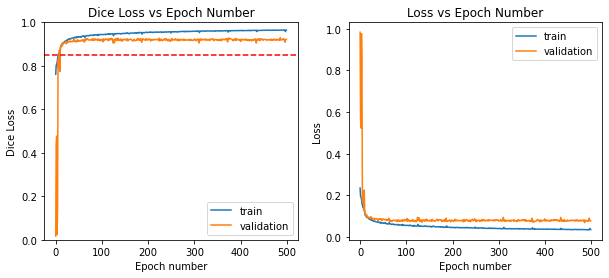

In [124]:
plot_history(unet_residual_dice.history, metric='dice_coef')
save_model_history(model_name, unet_residual_dice.history)

#### Evaluating the model after training

In [125]:
metrics = unet_residual_dice.evaluate(X_test, Y_test)
display_model_metrics(metrics)
save_model_metrics(model_name, metrics)

Dice coeficient loss: 0.31259405612945557
Dice coeficient: 0.6823663115501404


Delete the model.

In [126]:
del unet_residual_dice

### Optimization strategy 5.2: Dealing with class imbalance using dice loss and a large network

#### Prepare the data

Retrieve the number of training and validation steps for each epoch based on the total number of images and the batch size.

Create the train, validation and test generators. The train and validation images rely on the `DataAugmentationLoader` class to transform the images dynamicaly. The test generators will load all images from the test image folder using the `BatchLoader` class.

#### Display a few samples from the training dataset

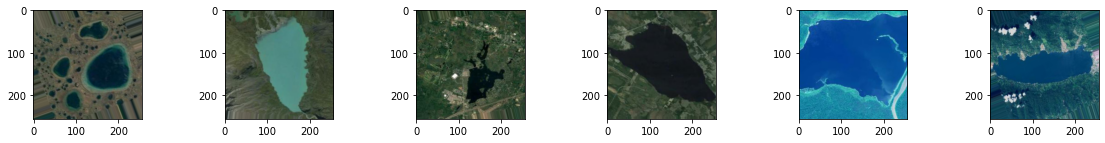

In [127]:
X_sample, Y_sample = next(train_generator)
display_training_samples(batch_size, X_sample)

#### Create the model and attach optimizer, loss, and metrics

In [128]:
unet_residual_large_dice = UnetResidual('unet-residual-large-dice', image_size, version=2)
model_name = unet_residual_large_dice.model_name
unet_residual_large_dice.set_compiler(dice_coef_loss, metrics=[dice_coef], optimizer=model_optimizer)

#### Model summary

In [129]:
unet_residual_large_dice.get_model_summary()

Model: "functional_19"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_252 (Conv2D)             (None, 256, 256, 32) 896         input_10[0][0]                   
__________________________________________________________________________________________________
batch_normalization_96 (BatchNo (None, 256, 256, 32) 128         conv2d_252[0][0]                 
__________________________________________________________________________________________________
conv2d_254 (Conv2D)             (None, 256, 256, 32) 128         input_10[0][0]                   
______________________________________________________________________________________

#### Evaluating the model before training

In [130]:
X_test, Y_test = next(test_generator)
metrics = unet_residual_large_dice.evaluate(X_test, Y_test)
display_model_metrics(metrics)

Dice coeficient loss: 0.7290287017822266
Dice coeficient: 0.27351024746894836


#### Setup callbacks and fit the model

In [131]:
callback_parameters = build_callback_parameters(model_name, 'val_dice_coef')
callbacks = build_callbacks(callback_parameters)
unet_residual_large_dice.fit(train_generator, train_steps, validation_generator, validation_steps, epochs, callbacks)
histories[model_name] = unet_residual_large_dice.history

Epoch 1/500
61/61 [==============================] - 37s 611ms/step - loss: 0.2450 - dice_coef: 0.7516 - val_loss: 0.6395 - val_dice_coef: 0.3605
Epoch 2/500
61/61 [==============================] - 36s 587ms/step - loss: 0.1960 - dice_coef: 0.8015 - val_loss: 0.9987 - val_dice_coef: 0.0013
Epoch 3/500
61/61 [==============================] - 36s 587ms/step - loss: 0.1882 - dice_coef: 0.8089 - val_loss: 0.9987 - val_dice_coef: 0.0013
Epoch 4/500
61/61 [==============================] - 36s 587ms/step - loss: 0.1812 - dice_coef: 0.8152 - val_loss: 0.9682 - val_dice_coef: 0.0318
Epoch 5/500
61/61 [==============================] - 36s 590ms/step - loss: 0.1795 - dice_coef: 0.8165 - val_loss: 0.6076 - val_dice_coef: 0.3924
Epoch 6/500
61/61 [==============================] - 36s 589ms/step - loss: 0.1730 - dice_coef: 0.8239 - val_loss: 0.4177 - val_dice_coef: 0.5823
Epoch 7/500
61/61 [==============================] - 36s 590ms/step - loss: 0.1707 - dice_coef: 0.8267 - val_loss: 0.2775 - 

#### Inspect and save the history

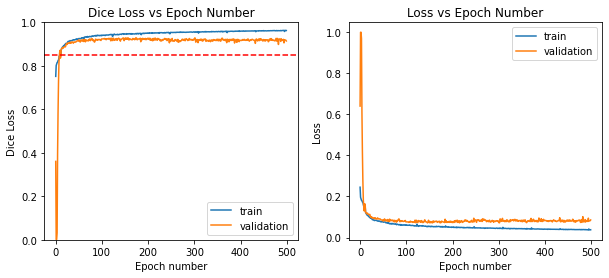

In [132]:
plot_history(unet_residual_large_dice.history, metric='dice_coef')
save_model_history(model_name, unet_residual_large_dice.history)

#### Evaluating the model after training

In [133]:
metrics = unet_residual_large_dice.evaluate(X_test, Y_test)
display_model_metrics(metrics)
save_model_metrics(model_name, metrics)

Dice coeficient loss: 0.3048769533634186
Dice coeficient: 0.7081815600395203


Delete the model.

In [134]:
del unet_residual_large_dice

## Compare the Results

### All models

#### Mean IoU

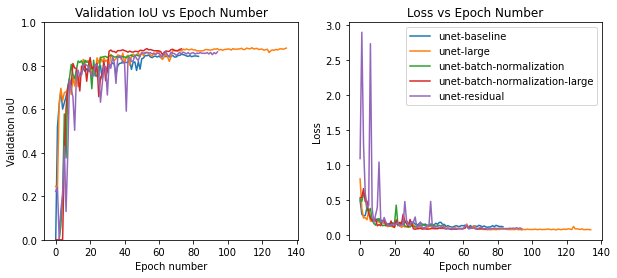

In [135]:
histories_iou = {title: history for title, history in histories.items() if not title.endswith("dice")}
plot_histories(histories_iou)

#### Dice Loss

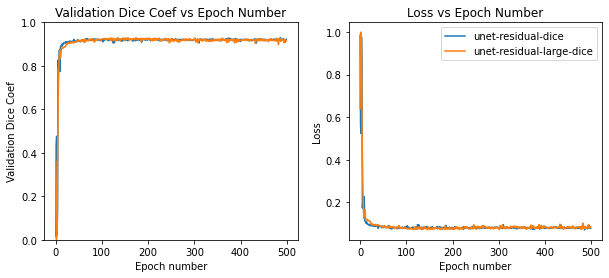

In [136]:
histories_iou = {title: history for title, history in histories.items() if title.endswith("dice")}
plot_histories(histories_iou, metric='dice_coef')

### Overall metrics

In [137]:
pprint.pprint(results, indent=2)

{ 'unet-baseline': { 'dice_coef': 0.7879212498664856,
                     'dice_coef_loss': 0.21207869052886963,
                     'iou': 0.7023693919181824,
                     'iou_loss': 0.29763063788414,
                     'loss': 0.20768220722675323},
  'unet-batch-normalization': { 'dice_coef': 0.7722836136817932,
                                'dice_coef_loss': 0.227716326713562,
                                'iou': 0.6679607033729553,
                                'iou_loss': 0.33203932642936707,
                                'loss': 0.29382801055908203},
  'unet-batch-normalization-large': { 'dice_coef': 0.757493257522583,
                                      'dice_coef_loss': 0.24250678718090057,
                                      'iou': 0.6668804287910461,
                                      'iou_loss': 0.33311963081359863,
                                      'loss': 0.23929846286773682},
  'unet-large': { 'dice_coef': 0.7636394500732422,
              

Clean up temporary files and folders.

In [138]:
training_folders = ['nwpu_images_train', 'nwpu_label_images_train']
validation_folders = ['nwpu_images_validation', 'nwpu_label_images_validation']
test_folders = ['s2cloudless_imagery', 's2cloudless_label_imagery']
[shutil.rmtree(folder) for folder in training_folders + validation_folders + test_folders]

[None, None, None, None, None, None]